# Script to benchmark WKT vs WKT vs PointXY


fetch timedelta tgeompoints, 

# WKB

results Desktop:

1. MMSI list fetched in 0.03388237953186035 seconds
2. min/max ts fetched in 0.5566732883453369 seconds
3. Time delta Tgeompoints fetched in 0.5069243907928467 seconds
4. Vector Layer created in 0.00994873046875 seconds
5. Features created in 0.043292999267578125 seconds
6. Average FPS : 15.061229102429822
7. On_new_frame average time : 0.06774496078491211
8. Value_at_timestamp average time : 0.06359884262084961
9. Updating geometries average time : 0.0041461181640625

In [ ]:
from enum import Enum
from datetime import timedelta
from pymeos.db.psycopg import MobilityDB
from pymeos import *
from shapely.geometry import Point
import time


class Time_granularity(Enum):
    # MILLISECOND = {"timedelta" : timedelta(milliseconds=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Milliseconds, "name" : "MILLISECOND"}
    SECOND = {"timedelta" : timedelta(seconds=1), "name" : "SECOND", "steps" : 1}
    MINUTE = {"timedelta" : timedelta(minutes=1), "name" : "MINUTE", "steps" : 1}
    # HOUR = {"timedelta" : timedelta(hours=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Hours, "name" : "HOUR"}

    @classmethod
    def set_time_step(cls, steps):
        Time_granularity.SECOND.value["timedelta"] = timedelta(seconds=steps)
        Time_granularity.SECOND.value["steps"] = steps
        Time_granularity.MINUTE.value["timedelta"] = timedelta(minutes=steps)
        Time_granularity.MINUTE.value["steps"] = steps
        return cls
    
SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
GRANULARITY = Time_granularity.set_time_step(1).MINUTE

connection_parameters = {
                'host': "localhost",
                'port': 5432,
                'dbname': DATABASE_NAME,
                'user': "postgres",
                'password': "postgres",
                'table_name': TPOINT_TABLE_NAME,
                'id_column_name': TPOINT_ID_COLUMN_NAME,
                'tpoint_column_name': TPOINT_COLUMN_NAME,
            }


######  MobilityDB connection ######
now = time.time()
pymeos_initialize()

connection_params = {
            "host": connection_parameters["host"],
            "port": connection_parameters["port"],
            "dbname": connection_parameters["dbname"],
            "user": connection_parameters["user"],
            "password": connection_parameters["password"],
            }


table_name = connection_parameters["table_name"]
id_column_name = connection_parameters["id_column_name"]
tpoint_column_name = connection_parameters["tpoint_column_name"]     
connection = MobilityDB.connect(**connection_params)

######  Fetching MMSI list  ######    
cursor = connection.cursor()
query = f"""
        SELECT {id_column_name} FROM public.{table_name} ;
        """

cursor.execute(query)
                
ids_list = cursor.fetchall()
now_2 = time.time()
print(f"1. MMSI list fetched in {now_2 - now} seconds")

objects_count = len(ids_list)
x_min,y_min, x_max, y_max = [-180, -90, 180, 90]
ids_list = [ f"'{id[0]}'"  for id in ids_list]
objects_id_str = ', '.join(map(str, ids_list))

######  Fetching min/max timestamp of dataset ######

cursor.execute(f"SELECT MIN(startTimestamp({tpoint_column_name})) AS earliest_timestamp FROM public.{table_name};")
min_ts =cursor.fetchone()[0]

cursor.execute(f"SELECT MAX(endTimestamp({tpoint_column_name})) AS latest_timestamp FROM public.{table_name};")
max_ts  = cursor.fetchone()[0]


end_ts = min_ts + (GRANULARITY.value["timedelta"] * 25)

now_3 = time.time()
print(f"2. min/max ts fetched in {now_3 - now_2} seconds")

######  Fetching Tgeompoints for subset 0 - 25 ######
query = f"""WITH trajectories as (
        SELECT 
            atStbox(
                a.{tpoint_column_name}::tgeompoint,
                stbox(
                    ST_MakeEnvelope(
                        {x_min}, {y_min}, -- xmin, ymin
                        {x_max}, {y_max}, -- xmax, ymax
                        {SRID} -- SRID
                    ),
                    tstzspan('[{min_ts}, {end_ts}]')
                )
            ) as trajectory
        FROM public.{table_name} as a 
        WHERE a.{id_column_name} in ({objects_id_str}))
    
        SELECT
                rs.trajectory
        FROM trajectories as rs ;"""

cursor.execute(query)
# print(f"query : {query}\n")
rows = cursor.fetchall()
now_4 = time.time()
print(f"3. Time delta Tgeompoints fetched in {now_4 - now_3} seconds")

######  Creating Vector Layer ######

vlayer = QgsVectorLayer("Point", "Benchmarking", "memory")
pr = vlayer.dataProvider()
pr.addAttributes([ QgsField("id", QVariant.String) ,QgsField("start_time", QVariant.DateTime), QgsField("end_time", QVariant.DateTime)])
vlayer.updateFields()
tp = vlayer.temporalProperties()
tp.setIsActive(True)
tp.setMode(qgis.core.QgsVectorLayerTemporalProperties.ModeFeatureDateTimeStartAndEndFromFields)
tp.setStartField("start_time")
tp.setEndField("end_time")
QgsProject.instance().addMapLayer(vlayer)

iface.mapCanvas().setDestinationCrs(QgsCoordinateReferenceSystem(f"EPSG:{SRID}"))
now_5 = time.time() 
print(f"4. Vector Layer created in {now_5 - now_4} seconds")

######  Creating QgisFeatures  ######    


features_list =[]
vfields = vlayer.fields()
start_datetime_obj = QDateTime(min_ts)
end_datetime_obj = QDateTime(max_ts)


geometries = {}
for i in range(1, objects_count+1):
    feat = QgsFeature(vfields)
    feat.setAttributes([ids_list[i-1],start_datetime_obj, end_datetime_obj])
    geom = QgsGeometry()
    geometries[i] = geom
    feat.setGeometry(geom)
    features_list.append(feat)

pr.addFeatures(features_list)
now_6 = time.time()
print(f"5. Features created in {now_6 - now_5} seconds")

######  On_new_frame  performance ######

on_new_frames_records = []
value_at_timestamp_records = []
updating_geometries_records = []

empty_point_wkb = Point().wkb

for frame in range(25):
    now_7 = time.time()
    timestamp = min_ts + GRANULARITY.value["timedelta"]  * frame
    
    for i in range(1, objects_count+1):
        try:
            position = rows[i-1][0].value_at_timestamp(timestamp)
            geometries[i].fromWkb(position.wkb) 
        except:
            geometries[i].fromWkb(empty_point_wkb)

    now_8 = time.time()
    value_at_timestamp_records.append(now_8 - now_7)

    vlayer.startEditing()
    pr.changeGeometryValues(geometries) # Updating geometries for all features
    vlayer.commitChanges()
    iface.vectorLayerTools().stopEditing(vlayer)
    now_9 = time.time()
    updating_geometries_records.append(now_9 - now_8)
    on_new_frames_records.append(now_9 - now_7)


fps_record = [1/frame_time for frame_time in on_new_frames_records]

average_fps = sum(fps_record)/len(fps_record)

print(f"6. Average FPS : {average_fps}")
print(f"7. On_new_frame average time : {sum(on_new_frames_records) / len(on_new_frames_records)}")
print(f"8. Value_at_timestamp average time : {sum(value_at_timestamp_records) / len(value_at_timestamp_records)}")
print(f"9. Updating geometries average time : {sum(updating_geometries_records) / len(updating_geometries_records)}")



# WKT


results Desktop:
1. MMSI list fetched in 0.03459334373474121 seconds
2. min/max ts fetched in 0.5492024421691895 seconds
3. Time delta Tgeompoints fetched in 0.49392223358154297 seconds
4. Vector Layer created in 0.01004338264465332 seconds
5. Features created in 0.04014229774475098 seconds
6. Average FPS : 12.501380429277749
7. On_new_frame average time : 0.08231148719787598
8. Value_at_timestamp average time : 0.07838180541992187
9. Updating geometries average time : 0.003929681777954101

In [ ]:
from enum import Enum
from datetime import timedelta
from pymeos.db.psycopg import MobilityDB
from pymeos import *
from shapely.geometry import Point
import time


class Time_granularity(Enum):
    # MILLISECOND = {"timedelta" : timedelta(milliseconds=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Milliseconds, "name" : "MILLISECOND"}
    SECOND = {"timedelta" : timedelta(seconds=1), "name" : "SECOND", "steps" : 1}
    MINUTE = {"timedelta" : timedelta(minutes=1), "name" : "MINUTE", "steps" : 1}
    # HOUR = {"timedelta" : timedelta(hours=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Hours, "name" : "HOUR"}

    @classmethod
    def set_time_step(cls, steps):
        Time_granularity.SECOND.value["timedelta"] = timedelta(seconds=steps)
        Time_granularity.SECOND.value["steps"] = steps
        Time_granularity.MINUTE.value["timedelta"] = timedelta(minutes=steps)
        Time_granularity.MINUTE.value["steps"] = steps
        return cls
    
SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
GRANULARITY = Time_granularity.set_time_step(1).MINUTE

connection_parameters = {
                'host': "localhost",
                'port': 5432,
                'dbname': DATABASE_NAME,
                'user': "postgres",
                'password': "postgres",
                'table_name': TPOINT_TABLE_NAME,
                'id_column_name': TPOINT_ID_COLUMN_NAME,
                'tpoint_column_name': TPOINT_COLUMN_NAME,
            }



######  MobilityDB connection ######
now = time.time()
pymeos_initialize()

connection_params = {
            "host": connection_parameters["host"],
            "port": connection_parameters["port"],
            "dbname": connection_parameters["dbname"],
            "user": connection_parameters["user"],
            "password": connection_parameters["password"],
            }


table_name = connection_parameters["table_name"]
id_column_name = connection_parameters["id_column_name"]
tpoint_column_name = connection_parameters["tpoint_column_name"]     
connection = MobilityDB.connect(**connection_params)

######  Fetching MMSI list  ######    
cursor = connection.cursor()
query = f"""
        SELECT {id_column_name} FROM public.{table_name} ;
        """

cursor.execute(query)
                
ids_list = cursor.fetchall()
now_2 = time.time()
print(f"1. MMSI list fetched in {now_2 - now} seconds")

objects_count = len(ids_list)
x_min,y_min, x_max, y_max = [-180, -90, 180, 90]
ids_list = [ f"'{id[0]}'"  for id in ids_list]
objects_id_str = ', '.join(map(str, ids_list))

######  Fetching min/max timestamp of dataset ######

cursor.execute(f"SELECT MIN(startTimestamp({tpoint_column_name})) AS earliest_timestamp FROM public.{table_name};")
min_ts =cursor.fetchone()[0]

cursor.execute(f"SELECT MAX(endTimestamp({tpoint_column_name})) AS latest_timestamp FROM public.{table_name};")
max_ts  = cursor.fetchone()[0]


end_ts = min_ts + (GRANULARITY.value["timedelta"] * 25)

now_3 = time.time()
print(f"2. min/max ts fetched in {now_3 - now_2} seconds")

######  Fetching Tgeompoints for subset 0 - 25 ######
query = f"""WITH trajectories as (
        SELECT 
            atStbox(
                a.{tpoint_column_name}::tgeompoint,
                stbox(
                    ST_MakeEnvelope(
                        {x_min}, {y_min}, -- xmin, ymin
                        {x_max}, {y_max}, -- xmax, ymax
                        {SRID} -- SRID
                    ),
                    tstzspan('[{min_ts}, {end_ts}]')
                )
            ) as trajectory
        FROM public.{table_name} as a 
        WHERE a.{id_column_name} in ({objects_id_str}))
    
        SELECT
                rs.trajectory
        FROM trajectories as rs ;"""

cursor.execute(query)
# print(f"query : {query}\n")
rows = cursor.fetchall()
now_4 = time.time()
print(f"3. Time delta Tgeompoints fetched in {now_4 - now_3} seconds")

######  Creating Vector Layer ######

vlayer = QgsVectorLayer("Point", "Benchmarking", "memory")
pr = vlayer.dataProvider()
pr.addAttributes([ QgsField("id", QVariant.String) ,QgsField("start_time", QVariant.DateTime), QgsField("end_time", QVariant.DateTime)])
vlayer.updateFields()
tp = vlayer.temporalProperties()
tp.setIsActive(True)
tp.setMode(qgis.core.QgsVectorLayerTemporalProperties.ModeFeatureDateTimeStartAndEndFromFields)
tp.setStartField("start_time")
tp.setEndField("end_time")
QgsProject.instance().addMapLayer(vlayer)

iface.mapCanvas().setDestinationCrs(QgsCoordinateReferenceSystem(f"EPSG:{SRID}"))
now_5 = time.time() 
print(f"4. Vector Layer created in {now_5 - now_4} seconds")

######  Creating QgisFeatures  ######    


features_list =[]
vfields = vlayer.fields()
start_datetime_obj = QDateTime(min_ts)
end_datetime_obj = QDateTime(max_ts)


geometries = {}
for i in range(1, objects_count+1):
    feat = QgsFeature(vfields)
    feat.setAttributes([ids_list[i-1],start_datetime_obj, end_datetime_obj])
    geom = QgsGeometry()
    geometries[i] = geom
    feat.setGeometry(geom)
    features_list.append(feat)

pr.addFeatures(features_list)
now_6 = time.time()
print(f"5. Features created in {now_6 - now_5} seconds")

######  On_new_frame  performance ######

on_new_frames_records = []
value_at_timestamp_records = []
updating_geometries_records = []

empty_point_wkt = Point().wkt

for frame in range(25):
    now_7 = time.time()
    timestamp = min_ts + GRANULARITY.value["timedelta"]  * frame
    
    for i in range(1, objects_count+1):
        try:
            position = rows[i-1][0].value_at_timestamp(timestamp)
            geometries[i] = QgsGeometry().fromWkt(position.wkt) 
        except:
            geometries[i]= QgsGeometry().fromWkt(empty_point_wkt)

    now_8 = time.time()
    value_at_timestamp_records.append(now_8 - now_7)

    vlayer.startEditing()
    pr.changeGeometryValues(geometries) # Updating geometries for all features
    vlayer.commitChanges()
    iface.vectorLayerTools().stopEditing(vlayer)
    now_9 = time.time()
    updating_geometries_records.append(now_9 - now_8)
    on_new_frames_records.append(now_9 - now_7)


fps_record = [1/frame_time for frame_time in on_new_frames_records]

average_fps = sum(fps_record)/len(fps_record)

print(f"6. Average FPS : {average_fps}")
print(f"7. On_new_frame average time : {sum(on_new_frames_records) / len(on_new_frames_records)}")
print(f"8. Value_at_timestamp average time : {sum(value_at_timestamp_records) / len(value_at_timestamp_records)}")
print(f"9. Updating geometries average time : {sum(updating_geometries_records) / len(updating_geometries_records)}")



# Point XY

results Desktop:

1. MMSI list fetched in 0.033403635025024414 seconds
2. min/max ts fetched in 0.5576505661010742 seconds
3. Time delta Tgeompoints fetched in 0.5065641403198242 seconds
4. Vector Layer created in 0.012407302856445312 seconds
5. Features created in 0.043254852294921875 seconds
6. Average FPS : 14.252336723148323
7. On_new_frame average time : 0.07167965888977051
8. Value_at_timestamp average time : 0.06773480415344238
9. Updating geometries average time : 0.003944854736328125


In [ ]:
from enum import Enum
from datetime import timedelta
from pymeos.db.psycopg import MobilityDB
from pymeos import *
from shapely.geometry import Point
import time


class Time_granularity(Enum):
    # MILLISECOND = {"timedelta" : timedelta(milliseconds=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Milliseconds, "name" : "MILLISECOND"}
    SECOND = {"timedelta" : timedelta(seconds=1), "name" : "SECOND", "steps" : 1}
    MINUTE = {"timedelta" : timedelta(minutes=1), "name" : "MINUTE", "steps" : 1}
    # HOUR = {"timedelta" : timedelta(hours=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Hours, "name" : "HOUR"}

    @classmethod
    def set_time_step(cls, steps):
        Time_granularity.SECOND.value["timedelta"] = timedelta(seconds=steps)
        Time_granularity.SECOND.value["steps"] = steps
        Time_granularity.MINUTE.value["timedelta"] = timedelta(minutes=steps)
        Time_granularity.MINUTE.value["steps"] = steps
        return cls
    
SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
GRANULARITY = Time_granularity.set_time_step(1).MINUTE

connection_parameters = {
                'host': "localhost",
                'port': 5432,
                'dbname': DATABASE_NAME,
                'user': "postgres",
                'password': "postgres",
                'table_name': TPOINT_TABLE_NAME,
                'id_column_name': TPOINT_ID_COLUMN_NAME,
                'tpoint_column_name': TPOINT_COLUMN_NAME,
            }


######  MobilityDB connection ######
now = time.time()
pymeos_initialize()

connection_params = {
            "host": connection_parameters["host"],
            "port": connection_parameters["port"],
            "dbname": connection_parameters["dbname"],
            "user": connection_parameters["user"],
            "password": connection_parameters["password"],
            }


table_name = connection_parameters["table_name"]
id_column_name = connection_parameters["id_column_name"]
tpoint_column_name = connection_parameters["tpoint_column_name"]     
connection = MobilityDB.connect(**connection_params)

######  Fetching MMSI list  ######    
cursor = connection.cursor()
query = f"""
        SELECT {id_column_name} FROM public.{table_name} ;
        """

cursor.execute(query)
                
ids_list = cursor.fetchall()
now_2 = time.time()
print(f"1. MMSI list fetched in {now_2 - now} seconds")

objects_count = len(ids_list)
x_min,y_min, x_max, y_max = [-180, -90, 180, 90]
ids_list = [ f"'{id[0]}'"  for id in ids_list]
objects_id_str = ', '.join(map(str, ids_list))

######  Fetching min/max timestamp of dataset ######

cursor.execute(f"SELECT MIN(startTimestamp({tpoint_column_name})) AS earliest_timestamp FROM public.{table_name};")
min_ts =cursor.fetchone()[0]

cursor.execute(f"SELECT MAX(endTimestamp({tpoint_column_name})) AS latest_timestamp FROM public.{table_name};")
max_ts  = cursor.fetchone()[0]


end_ts = min_ts + (GRANULARITY.value["timedelta"] * 25)

now_3 = time.time()
print(f"2. min/max ts fetched in {now_3 - now_2} seconds")

######  Fetching Tgeompoints for subset 0 - 25 ######
query = f"""WITH trajectories as (
        SELECT 
            atStbox(
                a.{tpoint_column_name}::tgeompoint,
                stbox(
                    ST_MakeEnvelope(
                        {x_min}, {y_min}, -- xmin, ymin
                        {x_max}, {y_max}, -- xmax, ymax
                        {SRID} -- SRID
                    ),
                    tstzspan('[{min_ts}, {end_ts}]')
                )
            ) as trajectory
        FROM public.{table_name} as a 
        WHERE a.{id_column_name} in ({objects_id_str}))
    
        SELECT
                rs.trajectory
        FROM trajectories as rs ;"""

cursor.execute(query)
# print(f"query : {query}\n")
rows = cursor.fetchall()
now_4 = time.time()
print(f"3. Time delta Tgeompoints fetched in {now_4 - now_3} seconds")

######  Creating Vector Layer ######

vlayer = QgsVectorLayer("Point", "Benchmarking", "memory")
pr = vlayer.dataProvider()
pr.addAttributes([ QgsField("id", QVariant.String) ,QgsField("start_time", QVariant.DateTime), QgsField("end_time", QVariant.DateTime)])
vlayer.updateFields()
tp = vlayer.temporalProperties()
tp.setIsActive(True)
tp.setMode(qgis.core.QgsVectorLayerTemporalProperties.ModeFeatureDateTimeStartAndEndFromFields)
tp.setStartField("start_time")
tp.setEndField("end_time")
QgsProject.instance().addMapLayer(vlayer)

iface.mapCanvas().setDestinationCrs(QgsCoordinateReferenceSystem(f"EPSG:{SRID}"))
now_5 = time.time() 
print(f"4. Vector Layer created in {now_5 - now_4} seconds")

######  Creating QgisFeatures  ######    


features_list =[]
vfields = vlayer.fields()
start_datetime_obj = QDateTime(min_ts)
end_datetime_obj = QDateTime(max_ts)


geometries = {}
for i in range(1, objects_count+1):
    feat = QgsFeature(vfields)
    feat.setAttributes([ids_list[i-1],start_datetime_obj, end_datetime_obj])
    geom = QgsGeometry()
    geometries[i] = geom
    feat.setGeometry(geom)
    features_list.append(feat)

pr.addFeatures(features_list)
now_6 = time.time()
print(f"5. Features created in {now_6 - now_5} seconds")

######  On_new_frame  performance ######

on_new_frames_records = []
value_at_timestamp_records = []
updating_geometries_records = []

# empty_point_wkt = Point().wkt

for frame in range(25):
    now_7 = time.time()
    timestamp = min_ts + GRANULARITY.value["timedelta"]  * frame
    
    for i in range(1, objects_count+1):
        try:
            position = rows[i-1][0].value_at_timestamp(timestamp)
            x, y = position.x, position.y
            geometries[i] = QgsGeometry.fromPointXY(QgsPointXY(x,y))
        except:
            geometries[i] = QgsGeometry()

    now_8 = time.time()
    value_at_timestamp_records.append(now_8 - now_7)

    vlayer.startEditing()
    pr.changeGeometryValues(geometries) # Updating geometries for all features
    vlayer.commitChanges()
    iface.vectorLayerTools().stopEditing(vlayer)
    now_9 = time.time()
    updating_geometries_records.append(now_9 - now_8)
    on_new_frames_records.append(now_9 - now_7)


fps_record = [1/frame_time for frame_time in on_new_frames_records]

average_fps = sum(fps_record)/len(fps_record)

print(f"6. Average FPS : {average_fps}")
print(f"7. On_new_frame average time : {sum(on_new_frames_records) / len(on_new_frames_records)}")
print(f"8. Value_at_timestamp average time : {sum(value_at_timestamp_records) / len(value_at_timestamp_records)}")
print(f"9. Updating geometries average time : {sum(updating_geometries_records) / len(updating_geometries_records)}")



# QGIS TASK Analysis

## FPS DIPS

In [6]:
import pickle 

with open(f'Solution_C_{30}_{0.1}_fps_record.pickle', 'rb') as f:
    fps_record = pickle.load(f)
fps_record

[46.65625486662662,
 40.19765770255506,
 37.239669714996005,
 36.07631040236707,
 35.140829612004325,
 34.34969616562659,
 33.69649642894443,
 32.892632239344394,
 33.236162507825064,
 31.5084023828662,
 31.610750192183048,
 30.637273378036845,
 31.913807009267572,
 31.472229308921737,
 31.86095834219562,
 32.173543512445825,
 31.91842139307647,
 29.926181727373265,
 30.321877304339026,
 29.983086590082138,
 30.77800933399865,
 30.635483164122416,
 30.029884514322944,
 29.569003440302296,
 30.185055378437312,
 30.596151321068525,
 30.73921200750469,
 28.672728018484843,
 30.95541532897893,
 22.458737604146588,
 27.521679790026248,
 25.11845060216432,
 24.62052853402834,
 20.21361066800322,
 16.102767678551547,
 28.272077112331907,
 27.646670313952185,
 28.35694437871423,
 27.179968376577932,
 27.68736797634136,
 28.17938364585503,
 27.229198179658134,
 26.76048106676875,
 28.228123780167714,
 27.169756565224713,
 26.814885850003517,
 28.110826642360227,
 26.810772112170085,
 26.9707612

In [4]:
with open(f'Solution_C_{30}_{0.1}_ts_record.pickle', 'rb') as f:
    ts = pickle.load(f)
ts

[[[datetime.datetime(2024, 7, 15, 23, 44, 58, 528332),
   datetime.datetime(2024, 7, 15, 23, 44, 58, 529708),
   datetime.datetime(2024, 7, 15, 23, 44, 58, 913993)]],
 [[datetime.datetime(2024, 7, 15, 23, 45, 7, 185121),
   datetime.datetime(2024, 7, 15, 23, 45, 7, 188364),
   datetime.datetime(2024, 7, 15, 23, 45, 7, 686329)]],
 [[datetime.datetime(2024, 7, 15, 23, 45, 9, 472405),
   datetime.datetime(2024, 7, 15, 23, 45, 9, 475214),
   datetime.datetime(2024, 7, 15, 23, 45, 9, 937501)]],
 [[datetime.datetime(2024, 7, 15, 23, 45, 11, 818701),
   datetime.datetime(2024, 7, 15, 23, 45, 11, 821437),
   datetime.datetime(2024, 7, 15, 23, 45, 12, 280125)]],
 [[datetime.datetime(2024, 7, 15, 23, 45, 14, 222730),
   datetime.datetime(2024, 7, 15, 23, 45, 14, 225461),
   datetime.datetime(2024, 7, 15, 23, 45, 14, 660672)]],
 [[datetime.datetime(2024, 7, 15, 23, 45, 16, 604545),
   datetime.datetime(2024, 7, 15, 23, 45, 16, 607156),
   datetime.datetime(2024, 7, 15, 23, 45, 17, 77975)]],
 [[da

In [5]:
with open(f'Solution_C_{30}_{0.1}_fps_ts_record.pickle', 'rb') as f:
    fps_ts = pickle.load(f)

fps_ts

[datetime.datetime(2024, 7, 15, 23, 45, 5, 411164),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 456178),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 506663),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 562727),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 619775),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 676659),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 735669),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 795469),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 855431),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 918814),
 datetime.datetime(2024, 7, 15, 23, 45, 5, 983268),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 46287),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 108366),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 171393),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 235211),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 296276),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 359037),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 425350),
 datetime.datetime(2024, 7, 15, 23, 45, 6, 490062),
 datetime.dat

Text(0.5, 0, 'Timestamp')

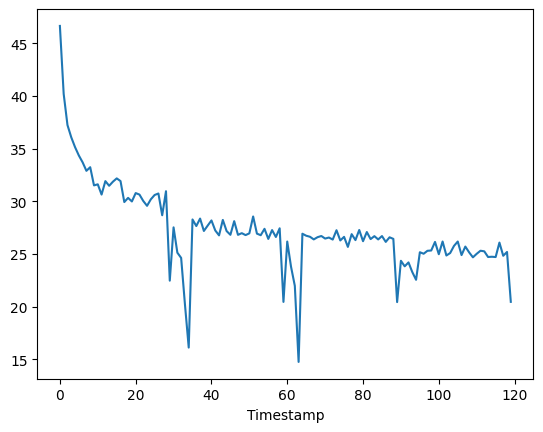

In [9]:
# plot fps_record

import matplotlib.pyplot as plt
import numpy as np

plt.plot(fps_record[:120])
plt.xlabel('Timestamp')

In [27]:
fps_record[55:65]

[26.42397515293169,
 27.26264884821382,
 26.607526199599075,
 27.433475047419712,
 20.440974506679144,
 26.175627351984872,
 23.782087047243202,
 21.9659170655578,
 14.740078228507368,
 26.916759184983153]

In [31]:
index = 63

In [32]:
fps_record[index]

14.740078228507368

In [33]:
fps_ts[index]

datetime.datetime(2024, 7, 15, 23, 45, 9, 884878)

In [34]:
tdelta = index // 30
# [Qgis Task Init; Run before fetch, Run after fetch]

ts[tdelta]

[[datetime.datetime(2024, 7, 15, 23, 45, 9, 472405),
  datetime.datetime(2024, 7, 15, 23, 45, 9, 475214),
  datetime.datetime(2024, 7, 15, 23, 45, 9, 937501)]]

## OVERHAD 

In [2]:
import pickle

In [2]:
with open(f"Solution_C_{30}_{0.1}_qgis_overhead.pickle", 'rb') as f:
    qgis_overheads = pickle.load(f)
qgis_overheads

[0.004481792449951172,
 0.002469778060913086,
 0.007851600646972656,
 0.0041882991790771484,
 0.030503511428833008,
 0.03114771842956543,
 0.010891199111938477,
 0.016581058502197266,
 0.004328012466430664,
 0.0045735836029052734,
 0.004176616668701172,
 0.004448652267456055,
 0.006395578384399414,
 0.0043561458587646484,
 0.003988027572631836,
 0.0045719146728515625,
 0.006986856460571289]

In [4]:
with open(f"Solution_C_{30}_{0.1}_qgis_time.pickle", 'rb') as f:
    qgis_task = pickle.load(f)
qgis_task

[0.5053145885467529,
 0.48077940940856934,
 0.5522422790527344,
 0.5050716400146484,
 0.488055944442749,
 0.46993517875671387,
 0.46329593658447266,
 0.5552237033843994,
 0.5214548110961914,
 0.4783284664154053,
 0.4411914348602295,
 0.44612550735473633,
 0.4579133987426758,
 0.45871663093566895,
 0.5327856540679932,
 0.4842231273651123,
 0.5702841281890869]

In [5]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the qgis_task trace
fig.add_trace(go.Scatter(
    x=list(range(len(qgis_task))),
    y=qgis_task,
    mode='lines',
    name='QGIS Task'
))

# Add the qgis_overheads trace
fig.add_trace(go.Scatter(
    x=list(range(len(qgis_overheads))),
    y=qgis_overheads,
    mode='lines',
    name='QGIS Overheads'
))

# Set the layout
fig.update_layout(
    title='QGIS Task and Overheads, 582 boats',
    xaxis_title='Index',
    yaxis_title='Time (s)'
)

# Show the figure
fig.show()

In [3]:
with open(f"Solution_C_{30}_{0.5}_qgis_overhead.pickle", 'rb') as f:
    qgis_overheads = pickle.load(f)
qgis_overheads

[0.0035550594329833984,
 0.0035614967346191406,
 0.004779815673828125,
 0.12932133674621582,
 0.004241228103637695,
 0.08974385261535645,
 0.06737875938415527,
 0.11027145385742188,
 0.0043299198150634766,
 0.08992743492126465,
 0.07818770408630371,
 0.004372835159301758,
 0.18305015563964844,
 0.005124807357788086,
 0.1979503631591797,
 0.004601716995239258,
 0.0054514408111572266]

In [4]:
with open(f"Solution_C_{30}_{0.1}_qgis_time.pickle", 'rb') as f:
    qgis_task = pickle.load(f)
qgis_task

[0.5053145885467529,
 0.48077940940856934,
 0.5522422790527344,
 0.5050716400146484,
 0.488055944442749,
 0.46993517875671387,
 0.46329593658447266,
 0.5552237033843994,
 0.5214548110961914,
 0.4783284664154053,
 0.4411914348602295,
 0.44612550735473633,
 0.4579133987426758,
 0.45871663093566895,
 0.5327856540679932,
 0.4842231273651123,
 0.5702841281890869]

In [5]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the qgis_task trace
fig.add_trace(go.Scatter(
    x=list(range(len(qgis_task))),
    y=qgis_task,
    mode='lines',
    name='QGIS Task'
))

# Add the qgis_overheads trace
fig.add_trace(go.Scatter(
    x=list(range(len(qgis_overheads))),
    y=qgis_overheads,
    mode='lines',
    name='QGIS Overheads'
))

# Set the layout
fig.update_layout(
    title='QGIS Task and Overheads, 2910 boats',
    xaxis_title='Index',
    yaxis_title='Time (s)'
)

# Show the figure
fig.show()